## TLDR;

- **Unsupervised Learning** -> Clustering algorithms are used for unsupervised learning, ideal for exploratory data analysis.
- **Grouping Data** -> These algorithms group similar data into clusters based on specific criteria.
- **Variety of Applications** -> They're used in diverse fields like customer segmentation, anomaly detection, and more.
- **Different Techniques** -> Various types exist, like K-means and DBSCAN, each with unique strengths and suited for specific data types.
- **Choice of Parameters** -> The selection and tuning of parameters, like the number of clusters, significantly influence the results.

In the vast field of machine learning, clustering algorithms hold a pivotal role. Used as a form of unsupervised learning, they uncover hidden patterns and structures within unlabeled data, making them instrumental for exploratory data analysis. The essence of clustering algorithms lies in their ability to sift through unstructured data and bring together similar items, forming distinct groups or 'clusters' based on defined criteria.

These algorithms have found their place in a myriad of real-world applications. From customer segmentation in marketing strategies, to image segmentation in computer vision, anomaly detection in cybersecurity, and dimensionality reduction in high-dimensional data—clustering algorithms are at the heart of insightful data-driven decision making.

The world of clustering algorithms is diverse, housing various types such as K-means, hierarchical, DBSCAN, and Gaussian Mixture Models, each coming with its unique strengths, limitations, and suitability for certain types of data.

A crucial aspect of working with these algorithms is the specification of parameters. While some algorithms like K-means require the user to define the number of clusters in advance, others, like DBSCAN, determine the number of clusters based on the data itself. The choice and tuning of these parameters can significantly steer the algorithm's effectiveness, making this a critical skill for any data practitioner.

In this blog post, we delve deeper into the intriguing world of clustering algorithms, demystifying their workings, exploring their varieties, and discussing how to choose and fine-tune parameters for optimal results. Stay tuned as we embark on this insightful journey.


## Data Preprocessing

In this initial stage, the goal is to prepare the data for analysis. This involves cleaning the data by removing or filling in missing values, which could be done through various strategies like dropping the missing rows, filling them with mean/median/mode, or using a prediction model. It's also crucial to handle outliers and potentially normalize features if they're on different scales. This stage might also involve dealing with categorical variables using encoding techniques. Effective preprocessing is crucial for reliable results in the subsequent stages.


#TODO add intro to the dataset
dataset can be found [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

| Field                  | Description                                                               |
| ---------------------- | ------------------------------------------------------------------------- |
| CustomerID             | Unique ID assigned to the customer                                        |
| Gender                 | Gender of the customer                                                    |
| Age                    | Age of the customer                                                       |
| Annual Income (k$)     | Annual income of the customer                                             |
| Spending Score (1-100) | Score assigned by the mall based on customer behavior and spending nature |


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.preprocessing import scale, StandardScaler

set_matplotlib_formats("svg")
sns.set_style("darkgrid")
plt.style.use("seaborn-v0_8-darkgrid")
FIGSIZE = (12, 6)

In [38]:
# | code-fold: show


# Load the customer dataset to analyze shopping patterns
df_mall = pd.read_csv("artifacts/Mall_Customers.csv")

# rename columns to be lowercase, for easy typing
df_mall = df_mall.rename(
    columns={
        "CustomerID ": "id",
        "Gender ": "gender",
        "Age ": "age",
        "Annual Income (k$) ": "income",
        "Spending Score (1-100)": "spending",
    }
)
df_mall["gender"] = df_mall["gender"].str.lower()
df_mall["gender"] = df_mall["gender"].str.strip()


# look at a random sample to validate the contents
display(df_mall.sample(6))

,id,gender,age,income,spending
6,7,female,35,18,6
4,5,female,31,17,40
36,37,female,42,34,17
62,63,female,67,47,52
7,8,female,23,18,94
175,176,female,30,88,86


Upon examination of the dataset, it appears that the 'gender' column is the only non-numeric feature. Specifically, it contains string values categorizing customers as either "Male" or "Female". All other columns - 'id', 'age', 'income', and 'spending' - are numeric data types.

The 'id' column seems to be a unique identifier for each customer. While numeric, this feature has very high cardinality (a distinct value for every customer). Features with high cardinality tend to dominate distance calculations in clustering algorithms and obscure more meaningful patterns in the data. Therefore, we should exclude the customer ID column from the feature set used for clustering.

For the remaining features to function effectively in clustering algorithms, the input features generally need to be numeric rather than categorical strings. Distance-based algorithms like k-means rely on computing distances between data points across features. String categories do not have an inherent numeric ordering, so the distance computations would not be meaningful.

Additionally, when performing exploratory analysis, a numeric encoding often allows easier visualization of the impact of gender relative to the other numeric features. Box plots, scatter plots with color-coded points, and other techniques can provide better insights into how gender correlates with shopper age, income or spending habits when mapped to a numeric form.

Therefore, to enable the application of clustering algorithms and more impactful analysis, we need to process the 'gender' column by encoding the categories as numbers. Common encoding schemes include mapping "Male" and "Female" to 0 and 1 respectively, or using one-hot encoding to create an additional binary feature column for each category. After encoding, gender will be represented numerically like the other existing features.

In summary, as gender is the only non-numeric column, and ID has high cardinality unsuitable for clustering, effectively preparing the data requires encoding the gender categorical data and excluding the customer ID column.


In [39]:
# | code-fold: show

# convert gender to a numerical value via one-hot-encoding
# clustering models usally need numerical values
df_mall = pd.get_dummies(df_mall, columns=["gender"], drop_first=True)

# list with features for easy reference
features = ["age", "income", "spending", "gender_male"]
df_feature = df_mall[features]


# look at a random sample to validate the contents
df_feature.sample(5)

,age,income,spending,gender_male
179,35,93,90,True
45,24,39,65,False
79,49,54,42,False
66,43,48,50,False
180,37,97,32,False


In [40]:
# | code-fold: show
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          200 non-null    int64
 1   income       200 non-null    int64
 2   spending     200 non-null    int64
 3   gender_male  200 non-null    bool 
dtypes: bool(1), int64(3)
memory usage: 5.0 KB


## Exploratory Data Analysis

Visualize the data and derive initial insights.


In [41]:
# | code-fold: show
display(df_feature.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
spending,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


The dataset contains information 200 customers. The average (mean) age is 38.85 years. Ages range from 18 to 70, with 50% of customers aged 36 years or below.

The average annual income is $60,560, ranging from $15,000 to $137,000. 50% of customers earn $61,500 or less.

For the spending score (1-100), the average is 50.2. Half the customers have a spending score of 50 or below. The minimum is 1 and maximum 99, showing a wide range in spending habits.

Overall, we see variation among customers in age, income levels, and purchasing patterns. Clustering algorithms can help segment customers into groups based on these attributes to develop targeted marketing approaches. let us first look at the distributions of the features.


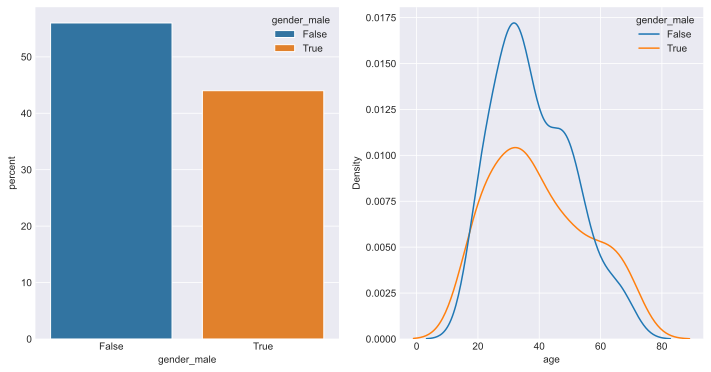

In [42]:
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

sns.countplot(
    data=df_feature, x="gender_male", stat="percent", hue="gender_male", ax=ax[0]
)

sns.kdeplot(x="age", data=df_feature, hue="gender_male", ax=ax[1]);

Text(0.5, 1.0, 'age vs. spending')

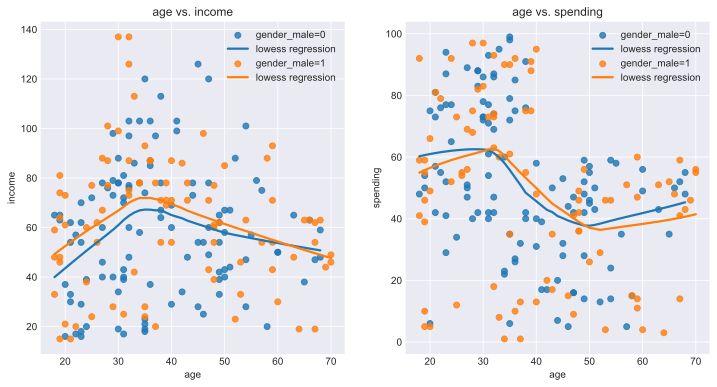

In [43]:
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

curr_ax = ax[0]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 0],
    x="age",
    y="income",
    color=sns.color_palette()[0],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)


curr_ax = ax[0]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 1],
    x="age",
    y="income",
    color=sns.color_palette()[1],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)
curr_ax.legend(
    ["gender_male=0", "lowess regression", "gender_male=1", "lowess regression"]
)
curr_ax.set_title("age vs. income")


curr_ax = ax[1]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 0],
    x="age",
    y="spending",
    color=sns.color_palette()[0],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)


curr_ax = ax[1]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 1],
    x="age",
    y="spending",
    color=sns.color_palette()[1],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)
curr_ax.legend(
    ["gender_male=0", "lowess regression", "gender_male=1", "lowess regression"]
)
curr_ax.set_title("age vs. spending")

<Axes: xlabel='income', ylabel='spending'>

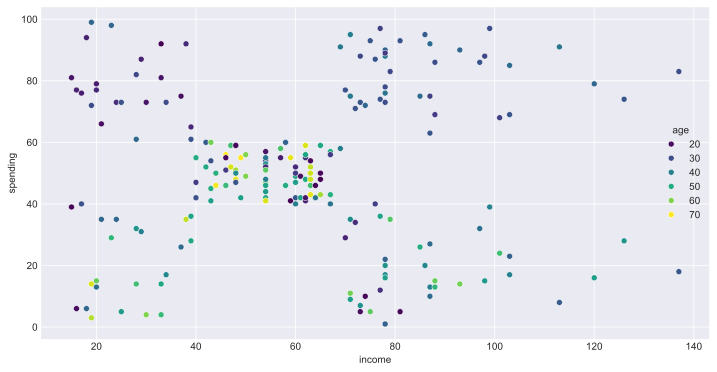

In [44]:
fig, ax = plt.subplots(1, figsize=FIGSIZE)
sns.scatterplot(
    data=df_feature,
    x="income",
    y="spending",
    hue="age",
    palette=sns.color_palette("viridis", as_cmap=True),
    ax=ax,
)

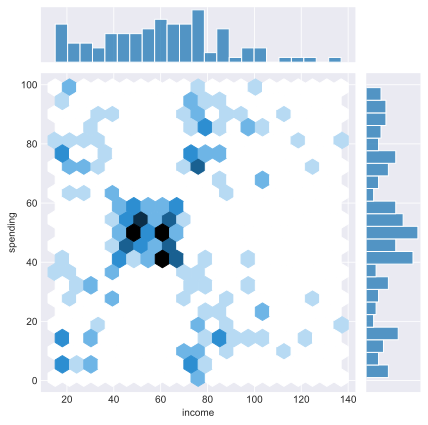

In [45]:
# fig, ax = plt.subplots(1, figsize=FIGSIZE)
ax = sns.jointplot(
    data=df_feature,
    kind="hex",
    x="income",
    y="spending",
    joint_kws={
        "gridsize": 20,
    },
    marginal_kws={"bins": 23},
)

In [46]:
def plot_umap(
    n_neighbors=15,
    min_dist=0.15,
    n_components=2,
    ax: plt.axes = None,
):
    # data structure, with the goal of a 2D representation.
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=min_dist,
        metric="euclidean",
    )

    # fit the data to the reducer
    embeddings = reducer.fit_transform(df_feature)

    # using the color_palette to obtain the correct coloring for plot
    # labels = [sns.color_palette()[x] for x in df_feature["gender_male"]]

    # create the scatter plot of the 2 component embedding
    # the order of x,y doesnt matter, the relative distance does
    ax.scatter(x=embeddings[:, 0], y=embeddings[:, 1], s=12, alpha=0.7)

    # remove axis labels and ticks
    # as these are meaningless for umap
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # n_neighbors are formatted as floats  and min_dist are formatted as int
    ax.set_title(f"{n_neighbors=:.0f} {min_dist=:.2f}")

In [47]:
# defining the parameter sweep
range_min_dist = np.linspace(0, 1, 4)  # min_dist
range_n_neighbors = np.arange(9, 13)  # n_neighbors

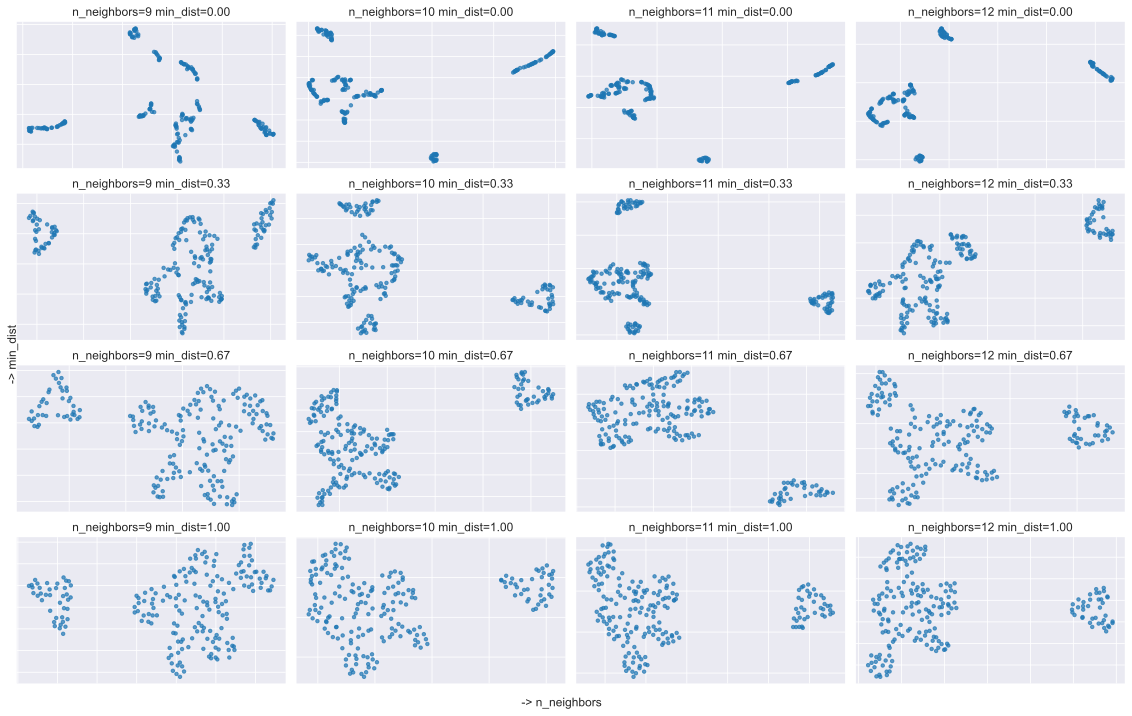

In [48]:
# creating the subplots and performing the embedding with the parameter sweep
fig, ax = plt.subplots(
    nrows=len(range_min_dist), ncols=len(range_n_neighbors), figsize=(16, 10)
)

for i_min_dist, min_dist in enumerate(range_min_dist):
    for i_n_neighbors, n_neighbors in enumerate(range_n_neighbors):
        plot_umap(
            n_neighbors=n_neighbors, min_dist=min_dist, ax=ax[i_min_dist, i_n_neighbors]
        )

fig.supxlabel(" -> n_neighbors")
fig.supylabel(" -> min_dist")
fig.tight_layout()
plt.show()

## Feature Engineering

Based on your EDA, create features that might help define customer segmentation, such as total purchase value, average purchase size, frequency of purchase, etc.


- create bins for the age bracket
- calculate descriptive stats for each bracket i.e mean spending size, income
- ratio of income of spending
- normalization of variables -> make comment on the distance calculations


In [49]:
# bin the age variable
binned = pd.cut(
    df_feature["age"],
    bins=[0, 20, 30, 40, 50, 60, 70, 80],
    labels=[
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ],
)
df_feature = df_feature.assign(age_bin=binned)
df_feature.sample(10)

,age,income,spending,gender_male,age_bin
169,32,87,63,True,3
4,31,17,40,False,3
183,29,98,88,False,2
137,32,73,73,True,3
195,35,120,79,False,3
74,59,54,47,True,5
176,58,88,15,True,5
3,23,16,77,False,2
55,47,43,41,True,4
79,49,54,42,False,4


In [50]:
# ratios
df_feature = df_feature.assign(
    ratio_spend_to_income=df_feature["spending"] / df_feature["income"],
    ratio_spend_to_age=df_feature["spending"] / df_feature["age"],
)
df_feature.head()

,age,income,spending,gender_male,age_bin,ratio_spend_to_income,ratio_spend_to_age
0,19,15,39,True,1,2.600000,2.052632
1,21,15,81,True,2,5.400000,3.857143
2,20,16,6,False,1,0.375000,0.300000
3,23,16,77,False,2,4.812500,3.347826
4,31,17,40,False,3,2.352941,1.290323


In [51]:
# turn off the formatter, to increase readability
# fmt: off
df_feature = df_feature.assign(
    income_vs_gender_mean=df_feature["income"] - df_feature.groupby("gender_male")[["income",]].transform("mean").iloc[:, 0],
    spending_vs_gender_mean=df_feature["spending"] - df_feature.groupby("gender_male")[["spending",]].transform("mean").iloc[:, 0],
)
# fmt: on

df_feature.sample(10)

,age,income,spending,gender_male,age_bin,ratio_spend_to_income,ratio_spend_to_age,income_vs_gender_mean,spending_vs_gender_mean
130,47,71,9,True,4,0.126761,0.191489,8.772727,-39.511364
116,63,65,43,False,6,0.661538,0.682540,5.750000,-8.526786
7,23,18,94,False,2,5.222222,4.086957,-41.250000,42.473214
18,52,23,29,True,5,1.260870,0.557692,-39.227273,-19.511364
43,31,39,61,False,3,1.564103,1.967742,-20.250000,9.473214
37,30,34,73,False,2,2.147059,2.433333,-25.250000,21.473214
87,22,57,55,False,2,0.964912,2.500000,-2.250000,3.473214
56,51,44,50,False,5,1.136364,0.980392,-15.250000,-1.526786
185,30,99,97,True,2,0.979798,3.233333,36.772727,48.488636
101,49,62,48,False,4,0.774194,0.979592,2.750000,-3.526786


In [52]:
df_feature.select_dtypes(include=np.number).columns

Index(['age', 'income', 'spending', 'ratio_spend_to_income',
       'ratio_spend_to_age', 'income_vs_gender_mean',
       'spending_vs_gender_mean'],
      dtype='object')

In [56]:
df_feature[df_feature.select_dtypes(include=np.number).columns] = df_feature.select_dtypes(include=np.number).apply(scale)

In [57]:
df_feature

,age,income,spending,gender_male,age_bin,ratio_spend_to_income,ratio_spend_to_age,income_vs_gender_mean,spending_vs_gender_mean
0,-1.424569,-1.738999,-0.434801,True,1,1.577244,0.462898,-1.805513,-0.369871
1,-1.281035,-1.738999,1.195704,True,2,4.460960,2.136786,-1.805513,1.263394
2,-1.352802,-1.700830,-1.715913,False,1,-0.714279,-1.162866,-1.653461,-1.770412
3,-1.137502,-1.700830,1.040418,False,2,3.855894,1.664337,-1.653461,0.990584
4,-0.563369,-1.662660,-0.395980,False,3,1.322799,-0.244230,-1.615230,-0.448245
...,...,...,...,...,...,...,...,...,...
195,-0.276302,2.268791,1.118061,False,3,-0.422475,0.652605,2.322491,1.068358
196,0.441365,2.497807,-0.861839,False,4,-0.871625,-0.863968,2.551873,-0.914892
197,-0.491602,2.497807,0.923953,True,3,-0.495630,0.703955,2.438051,0.991183
198,-0.491602,2.917671,-1.250054,True,3,-0.965176,-0.919368,2.858584,-1.186504


## Clustering

Use a suitable clustering algorithm (like K-means or hierarchical clustering) to divide customers into distinct groups.


## Analysis and Evaluation

Analyze each customer group's traits, like average age or buying habits. Use metrics like Silhouette Score or Dunn Index to assess clustering quality, evaluating cluster cohesion and separation. A successful clustering result scores well on these metrics and provides actionable business insights.


## Insights and Business Applications

Explain how the results could be used to tailor marketing strategies towards each segment for improved customer engagement and retention.
